# Imports

In [47]:
import pandas as pd
import numpy as np
from IPython import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.metrics as met
from IPython.display import Image
from tensorflow import keras
from keras.src.layers import Input, Dense, BatchNormalization
from keras import Model

# Voeg libraries toe indien nodig
from functions.functions_Y2.ANN import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score

# Eigen functies
Als je zelfgemaakte functies gebruikt in je antwoorden plaats de functie zelf dan in de cel hieronder

In [48]:
# Plaats hier de in de antwoorden gebruikte functies die je zelf gemaakt hebt.
def lda_info(lda: LinearDiscriminantAnalysis, X, do_print: bool = False):
    """
    Return or print the info of the given LDA.
    :param lda: The linear discriminant analysis object.
    :param X: The list of independent objects of the lda.
    :param do_print: Print the output of the function instead of returning the output

    :returns dfs1: The prior probabilities of groups.
    :returns dfs2: The group means
    :returns dfs3: The coefficients of linear discriminants
    :returns dimensions: The dimensions of the lda
    """
    df1 = pd.DataFrame(lda.priors_, index=lda.classes_, columns=['prior probabilities'])
    df2 = pd.DataFrame(lda.means_, index=lda.classes_, columns=X.columns)
    df3 = pd.DataFrame(lda.scalings_, index=X.columns,
                       columns=['LD' + str(i + 1) for i in range(lda.scalings_.shape[1])])
    dfs1 = df1.style.set_caption('Prior probabilities of groups')
    dfs2 = df2.style.set_caption('Group means')
    dfs3 = df3.style.set_caption('Coefficients of linear discriminants')
    dimensions = min(X.columns.size, lda.classes_.size - 1)
    if do_print:
        display(dfs1)
        display(dfs2)
        display(dfs3)
        print(f'The LD has {dimensions} dimension(s)')
    return dfs1, dfs2, dfs3, dimensions


def accuracy(confusion_matrix: pd.DataFrame):
    classes = len(confusion_matrix.index)
    sumT = 0
    for i in range(classes - 1):
        sumT += confusion_matrix.iloc[i, i]
    return sumT / confusion_matrix.iloc[classes - 1, classes - 1]


def precision(confusion_matrix: pd.DataFrame, target: str):
    classes = confusion_matrix.index
    return confusion_matrix.loc[target, target] / confusion_matrix.loc[classes[len(classes) - 1], target]


def recall(confusion_matrix: pd.DataFrame, target: str):
    classes = confusion_matrix.index
    return confusion_matrix.loc[target, target] / confusion_matrix.loc[target, classes[len(classes) - 1]]


def f1_score(confusion_matrix: pd.DataFrame, target: str, β: float = 1):
    pr = precision(confusion_matrix, target)
    rc = recall(confusion_matrix, target)
    return ((pow(β, 2) + 1) * pr * rc) / ((pow(β, 2) * pr) + rc)


def evaluate(confusion_matrix: pd.DataFrame, β: float = 1, extended_output: bool = False, do_print: bool = False):
    classes = confusion_matrix.index.tolist()
    classes.pop()
    acc = accuracy(confusion_matrix)
    precisions = pd.DataFrame([precision(confusion_matrix, cls) for cls in classes], columns=["Class Precision"],
                              index=classes).T
    recalls = pd.DataFrame([recall(confusion_matrix, cls) for cls in classes], columns=["Class Recall"], index=classes)

    f1 = pd.DataFrame([f1_score(confusion_matrix, cls, β=β) for cls in classes], columns=[f"F{β}-Score"], index=classes)

    combined = pd.concat([confusion_matrix, precisions]).join(recalls).join(f1)
    if extended_output:
        return acc, precisions, recalls, f1, combined
    if do_print:
        print(f'The accuracy is: {acc}')
        display(combined)
        return
    return acc, combined


def plot_roc(y_true, y_score, title='ROC Curve', **kwargs):
    if 'pos_label' in kwargs:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score, pos_label=kwargs.get('pos_label'))
        auc = roc_auc_score(y_true, y_score)
    else:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auc = roc_auc_score(y_true, y_score)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    figsize = kwargs.get('figsize', (7, 7))
    fix, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(linestyle='--')

    ax.plot(fpr, tpr, color='darkorange', label='AUC: {}'.format(auc))
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (FPR)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange', edgecolor='black')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.scatter(fpr[optimal_idx], tpr[optimal_idx],
               label='optimat cutoff {:.2f} op ({:.2f},{:.2f})'.format(optimal_threshold, fpr[optimal_idx],
                                                                       tpr[optimal_idx]), color='red')
    ax.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], linestyle='--', color='red')
    ax.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], linestyle='--', color='red')
    ax.legend(loc='lower right')
    plt.show()

# Vraag 1 (1 punt)

Iemand wil een LDA model maken om de *price_range* van een gsm te voorspellen. Hij gebruikt daarvoor 8 onafhankelijke variabelen. Hoeveel lineaire discriminant functies zal zijn model bevatten? *We vragen dus niet om een model te maken, maar enkel om het aantal lineaire discriminant functies te bepalen.*

## Antwoord
3 LDA functies

# Vraag 2
## a. (1 punt) 
Maak nu zelf een LDA model waarbij je op basis van *battery_power*, *clock_speed*, *fc*, *int_memory*, *n_cores*, *pc*, *ram* en *talk_time* tracht te voorspellen of de prijs van de gsm in de hoogste klasse zit. De afhankelijke variabele is dus niet gewoon price_range maar heeft als waarde True indien *price_range* == 3.

In [49]:
examen_dataset = pd.read_csv('CellPhone_train.csv', delimiter=",")

examen_dataset

,Unnamed: 0.1,Unnamed: 0,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,predicted_price_range,predicted_price_range_proba
0,0,0,842,0,2.2,0,1,0,7,0.6,...,2549,9,7,19,0,0,1,1,2,0.228768
1,1,1,1021,1,0.5,1,0,1,53,0.7,...,2631,17,3,7,1,1,0,2,2,0.219890
2,2,2,563,1,0.5,1,2,1,41,0.9,...,2603,11,2,9,1,1,0,2,2,0.245067
3,3,3,615,1,2.5,0,0,0,10,0.8,...,2769,16,8,11,1,0,0,2,2,0.177855
4,4,4,1821,1,1.2,0,13,1,44,0.6,...,1411,8,2,15,1,1,0,1,1,0.400540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1995,794,1,0.5,1,0,1,2,0.8,...,668,13,4,19,1,1,0,0,0,0.471320
1996,1996,1996,1965,1,2.6,1,0,0,39,0.2,...,2032,11,10,16,1,1,1,2,2,0.207789
1997,1997,1997,1911,0,0.9,1,1,1,36,0.7,...,3057,9,1,5,1,1,0,3,3,0.127551
1998,1998,1998,1512,0,0.9,0,4,1,46,0.1,...,869,18,10,19,1,1,1,0,0,0.360317


In [50]:
X = examen_dataset[['battery_power', 'clock_speed', 'fc', 'int_memory', 'n_cores', 'pc', 'ram', 'talk_time']]

X

y = examen_dataset['price_range'].apply(lambda x: True if x == 3 else False)

y

,battery_power,clock_speed,fc,int_memory,n_cores,pc,ram,talk_time
0,842,2.2,1,7,2,2,2549,19
1,1021,0.5,0,53,3,6,2631,7
2,563,0.5,2,41,5,6,2603,9
3,615,2.5,0,10,6,9,2769,11
4,1821,1.2,13,44,2,14,1411,15
...,...,...,...,...,...,...,...,...
1995,794,0.5,0,2,6,14,668,19
1996,1965,2.6,0,39,4,3,2032,16
1997,1911,0.9,1,36,8,3,3057,5
1998,1512,0.9,4,46,5,5,869,19


0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997     True
1998    False
1999     True
Name: price_range, Length: 2000, dtype: bool

In [51]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis()

### b. (1 punt)
Wat zijn de coëfficiënten van de eerste discriminant functie? 

In [52]:
lda_info(lda, X, do_print=True)

,prior probabilities
False,0.750000
True,0.250000


,battery_power,clock_speed,fc,int_memory,n_cores,pc,ram,talk_time
False,1191.363333,1.522867,4.307333,31.403333,4.526667,9.838667,1682.540000,10.982000
True,1379.984000,1.520400,4.316000,33.976000,4.502000,10.150000,3449.232000,11.098000


,LD1
battery_power,0.000855
clock_speed,-0.015213
fc,-0.010454
int_memory,0.004280
n_cores,-0.001439
pc,0.003935
ram,0.001301
talk_time,-0.003131


The LD has 1 dimension(s)


(<pandas.io.formats.style.Styler at 0x2bbb3b12dd0>,
 1)

De coëfficiënten van de eerste LDA zijn:
- 0.000855
- -0.015213
- -0.015213
- -0.010454
- 0.004280
- -0.001439
- 0.003935
- 0.001301
- -0.003131

# Vraag 3
In de kolom *predicted_price_range* vind je de voorspelde *price_range* waarden van een AI model (waarover we verder niet in detail gaan).

## a. (1,5 punten)
Bereken *precision*, *recall*, en *F1-score* voor elke klasse.

In [53]:
y = examen_dataset['price_range']
predicted = examen_dataset['predicted_price_range']

cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=predicted, labels=np.unique(np.array(predicted))))

tot = cm.join(pd.DataFrame(cm.sum(axis=1), columns=["Totaal"]))

cm = pd.concat([tot, pd.DataFrame(tot.sum(axis=0), columns=['Totaal']).T])

cm

,0,1,2,3,Totaal
0,461,39,0,0,500
1,54,379,67,0,500
2,0,71,362,67,500
3,0,0,62,438,500
Totaal,515,489,491,505,2000


In [54]:
evaluate(cm, do_print=True)

The accuracy is: 0.82


,0,1,2,3,Totaal,Class Recall,F1-Score
0,461.000000,39.000000,0.000000,0.000000,500.0,0.922,0.908374
1,54.000000,379.000000,67.000000,0.000000,500.0,0.758,0.766431
2,0.000000,71.000000,362.000000,67.000000,500.0,0.724,0.730575
3,0.000000,0.000000,62.000000,438.000000,500.0,0.876,0.871642
Totaal,515.000000,489.000000,491.000000,505.000000,2000.0,NaN,NaN
Class Precision,0.895146,0.775051,0.737271,0.867327,NaN,NaN,NaN


- Precision:
    - 0: 0.90
    - 1: 0.76
    - 2: 0.74
    - 3: 0.87
- Recall:
    - 0: 0.92
    - 1: 0.76
    - 2: 0.72
    - 3: 0.88
- F1-score:
    - 0: 0.91
    - 1: 0.77
    - 2: 0.73
    - 3: 0.87

## b. (1,5 punten)
Voor welke klasse is het model het best in staat een voorspelling te doen? Op basis van welke informatie heb je dit beslist?

Het model is het beste in staat om voor klasse '0' een voorspelling te maken. Van deze klasse is de F1-score de hoogste van ze allemaal met 91%. Al de andere klasse hebben ook zeer hoge scores, maar die van '0' heeft de hoogste.

# Vraag 4

## a. (1 punt)
In een ander getraind AI-model hebben we onze focus gelegd op de gsm's in de middelste prijsklasse. We trachten in dit model te voorspellen of een gsm al dan niet in de prijsklasse 1 zit. De werkelijke waarde van de afhankelijke variabele is met andere woorden *price_range* == 1.

In de kolom *predicted_price_range_proba* vind je de voorspelde kansen dat een gsm in die middelste prijsklasse zit volgens het model.

Gebruik deze kolom om op basis van deze voorspelde kansen een ROC curve te tekenen. Wat is de AUC? 

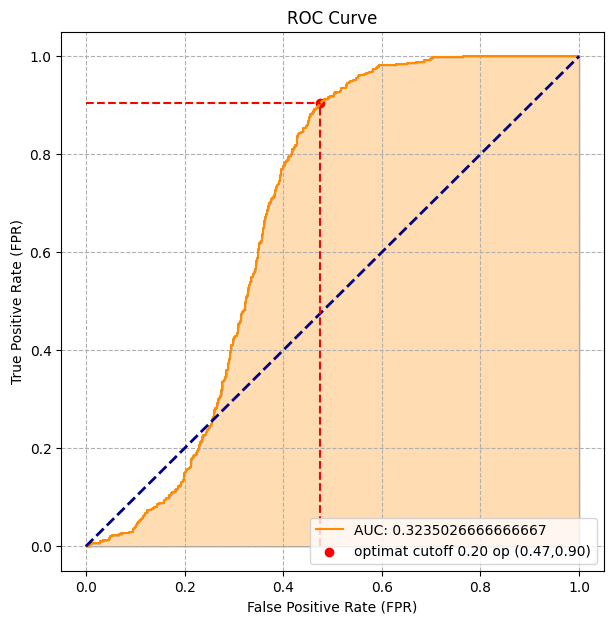

In [55]:
y_true = examen_dataset['price_range'].apply(lambda x: 'medium' if x == 1 else 'other')
y_score = examen_dataset['predicted_price_range_proba']

plot_roc(y_true=y_true, y_score=y_score, pos_label='medium')

## b. (1 punt)
Wat is het optimal cutoff point voor deze ROC curve? Wat wil dit zeggen? 

## ANTWOORD
De optimale cutoff is 0.2.

Dit is een zeer slechte waarde, de score zou meer precision gericht zijn maar waarschijnlijk zullen de voorspellingen fout zijn.

De optimal cutoff point is de optimale β waarde om mee te geven aan de F score voor het beste resultaat te behalen
Een lage score onder 1 is meer precision gericht en boven de 1 meer recall gericht


# Vraag 5 (2 punten)
Op de afbeelding hiernaast zie je de resultaten van een getraind neuraal netwerk. In dit model worden geen biases/constante nodes gebruikt. Bij de outputlayer werd one-hot encoding toegepast.


## a.
Hoeveel inputvariabelen heeft dit netwerk?

### ANTWOORD
3

## b.
Hoeveel categorieën heeft de onafhankelijke (te voorspellen) variabele?

### ANTWOORD
2

## c.
Welke node uit de hidden layer heeft de grootste invloed op node 2 van de output layer? Geef de naam die boven de node staat.

### ANTWOORD
H1

## d.
In de nodes zie je een schematische weergave van de activatiefunctie. Welke activatiefunctie wordt hier gebruikt?

### ANTWOORD
Tahn functie

# Vraag 6 (3 punten)
Train een neuraal netwerk met volgende specificaties:
* De inputlayer heeft een ode voor elk van de volgende variabelen:
    * *battery_power*
    * *clock_speed*
    * *fc*
    * *int_memory*
    * *n_cores*
    * *pc*
    * *ram*
    * *talk_time*
* De afhankelijke variabele (Y) is *price_range*
* Pas BatchNormalization toe op de inputlayer om de data te normaliseren.
* De (enige) hidden layer heeft 8 nodes en gebruikt de ReLU activatiefunctie.
* De outputlayer heeft 4 nodes voor elke categorie van *price_range* en gebruikt de softmax activatiefunctie.
* Gebruik ```model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.10), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])``` om het model te compileren.
* Train het model gedurende 10 epochs met een batch_size van 32 en een validation_split van 0.2. We moeten in de output kunnen zien dat het model getraind werd.

In [57]:
#ANTWOORD
x_data = examen_dataset[['battery_power', 'clock_speed', 'fc', 'int_memory', 'n_cores', 'pc', 'ram', 'talk_time']]

y_data = examen_dataset['price_range']

y_data = to_categorical(y_data)

inputs = Input(shape=(8,))
inputs = BatchNormalization()(inputs)
hidden = Dense(8, activation='relu')(inputs)
outputs = Dense(4, activation='softmax')(hidden)

model = Model(inputs, outputs, name='NN')
model.compile(optimizer=Adam(learning_rate=0.10),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x_data, y_data, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2656 - loss: 143.2116 - val_accuracy: 0.2475 - val_loss: 1.3871
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2460 - loss: 1.3915 - val_accuracy: 0.2375 - val_loss: 1.3967
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2615 - loss: 1.3880 - val_accuracy: 0.2550 - val_loss: 1.3877
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2456 - loss: 1.3911 - val_accuracy: 0.2475 - val_loss: 1.3896
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2606 - loss: 1.3916 - val_accuracy: 0.2550 - val_loss: 1.3901
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2595 - loss: 1.3915 - val_accuracy: 0.2550 - val_loss: 1.3904
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2331 - loss: 1.3942 - val_accuracy: 0.2550 - val_loss: 1.3901
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2276 - loss: 1.3932 - val_accuracy: 0.2475 - val_los

# Vraag 7 (2 punten)
In de code onder de vraag zie je 10 chromosomen. Ook de doelfunctie waarvan we het resultaat willen maximaliseren is gegeven. Welke van deze oplossingen zal volgens het roulette selectiemechanisme het meeste kans maken om geselcteerd te worden voor mating/paring? Waarom?  

In [58]:
import math

x1 = [1.0, 0.5]
x2 = [-0.5, -0.5]
x3 = [1.0, 1.0]
x4 = [-0.75, -0.75]
x5 = [-0.5, 0.0]
x6 = [-0.5, -1.0]
x7 = [0.5, 0.5]
x8 = [0.5, 0.0]
x9 = [0.75, 0.75]
x10 = [-1.2, -1.0]


def energy(x):
    return ((0.2 + x[0] * x[0] + x[0] * x[1] - 0.1 * np.cos(1.0 * math.pi * x[0]) - 0.1 * np.cos(-2.0 * np.pi * x[1])))


In [59]:
energy(x1)
energy(x2)
energy(x3)
energy(x4)
energy(x5)
energy(x6)
energy(x7)
energy(x8)
energy(x9)
energy(x10)

1.9000000000000001

0.7999999999999999

2.2

1.3957106781186548

0.35

0.85

0.7999999999999999

0.35

1.3957106781186548

2.8209016994374947

## Antwoord

x10 maakt het meeste kans om door de roulette gekozen te worden. De energy functie zal worden gecalled bij het kiezen van een nieuw chromosoon en ieder chromosoon zal zijn energie toegewezen krijgen, daarna wordt er "aan een wiel gedraaid en hoe groter de energy hoe groter het vlak op die wiel." chromosoon **x10** heeft het grootste oppervlak.

# Vraag 8 (2 punten)
In de code bij vraag 8 vind je een dataframe. Deze bevat de scores van de doelfunctie voor een generatie chromosomen. Het optimalisatieprobleem is een minimalisatieprobleem. Voor de selectie van de chromosomen die mogen paren/maten wordt het tournament selectie mechanisme gebruikt.

Voor de eerste selecteren chromosoom werd in de eerste stap van het selectie-algoritme chromosomen 1, 3, 6, 8 en 20 geselecteerd. Welke van deze chromosomen zal in aanmerking komen voor 'mating/paring'? Met andere woorden wat is het resultaat van deze selecte-operatie? Waarom?

In [1]:
populatie = pd.DataFrame({'chromosoon': range(1, 21),
                          'score_doelfunctie': [247.6251629, 214.51757898, 249.13309669, 188.81888775, 104.80883904,
                                                316.12006777, 198.56246032, 465.06055288, 156.80288596, 243.7813792,
                                                185.9045345, 146.50208061, 119.45574293, 364.05258658, 416.80157775,
                                                481.66470259, 412.22107183, 421.06760396, 227.18712982, 229.35077602]})
populatie

NameError: name 'pd' is not defined

#ANTWOORD
Van de geselcteerde chromosonen: 1, 3, 6, 8 en 20 zal chromosoon **8** worden gekozen. Bij het Tournament selectie worden de chromosonen tegen elkaar opgezet en de chromosoon met de hoogste score zal worden geselecteerd. Chromosoon 8 heeft een score van 465 wat bijna 2 keer zo hoog is als de sterkste tegenstander.


# Vraag 9 
Onder vraag 9 zie je de code voor het oplossen van een Sudoku met simulated annealing. Je krijgt een startbestand en het is de bedoeling de nullen te vervangen door de cijfers 1 tot en met 9. Bij het oplossen hou je rekening met volgende Sudoku contraints:
- In elke rij de getallen 1 tot en met 9 exact 1 keer voorkomen.
- In elke kolom de getallen 1 tot en met 9 exact 1 keer voorkomen.
*In een echte Sudoku is je veld ook verdeeld in 9 blokken van 3\*3. In elk blok moet elk getal van 1 tot en met 9 exact 1 keer voorkomen. Deze laatste regel implementeren we niet voor deze heuristiek.*

Bij deze heuristiek lees je eerst een startSituatie van een sudoku in waarbij de in te vullen waarbij de in te vullen waarden gelijk zijn aan 0 (zie csv). Het grootste deel van de code is al uitgewerkt.

- Cel 1: StartSituatie inlezen > leest de sudoku in. Hierin pas je niet aan.
- Cel 2: emptyfields aanmaken > maakt een lijst van de indices van de lege velden. Hierin pas je niets aan.
- Cel 3: Simulated annealing klasse > bevat de klasse Sudoku die de simulated annealing uitvoert.

In [61]:
#CEL 1: Startsituatie inlezen (NIETS AANPASSEN)
## 
from simanneal import Annealer

board = pd.read_csv('sudoku.csv', header=None)

In [62]:
#CEL 2: emptyfields aanmaken (NIETS AANPASSEN)
# Code om de indexen van de lege velden in een list te steken [Niet aanpassen]
board_emptyFields = board == 0
emptyfields = np.where(board_emptyFields.to_numpy().flatten() == True)[
    0].tolist()  #De indices van de lege velden (velden met nul)

## a. (2 punten)
Werk in Cel 3 de move functie uit. Je weight bij een move slechts één willekeurig veld van de Sudoku naar een andere waarde. Enkel velden die nog niet zijn ingevuld waren bij de startSituatie (waarde = 0) mogen gewijzigd worden. (tip: emptyfields bevat de indices van de lege velden)

In [63]:
#CEL 3: Simulated annealing klasse
class Sudoku(Annealer):
    # ENGERGY FUNCTIE NIET AANPASSEN
    def energy(self):
        s = pd.DataFrame(self.state.reshape(9, 9))
        lineTotal = 45
        lineSums = pd.concat([s.sum(axis=1), s.sum(axis=0)])  #Telt de som van de inhoud van de rijen en de kolommen 
        valueCounts = pd.Series(np.unique(s, return_counts=True))[
            1]  #Telt hoe vaak elk getal voorkomt in een rij of kolom
        valueCountErrorCost = np.absolute(valueCounts - 9).sum() * 10
        lineValueErrorCost = np.absolute(lineSums - lineTotal).sum() * 2
        return valueCountErrorCost + lineValueErrorCost

    #ANTWOORD
    def move(self):
        i = np.random.randint(0, len(self.state))
        while i not in emptyfields:
            i = np.random.randint(0, len(self.state))

        self.state[i] = np.random.randint(1, 10)

## b. (1 punt)
Voer de heuristiek uit door de 4 cellen na elkaar uit te voeren.

In [64]:
problem = Sudoku(np.array(board))
problem.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


(array([[5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6],
        [0, 9, 0, 3, 0, 6, 0, 0, 0],
        [0, 0, 0, 0, 0, 9, 0, 0, 0],
        [7, 7, 7, 7, 7, 7, 7, 7, 7],
        [1, 0, 0, 6, 0, 5, 0, 0, 0],
        [3, 3, 3, 3, 3, 3, 3, 3, 3],
        [9, 9, 9, 9, 9, 9, 9, 9, 9],
        [8, 8, 8, 8, 8, 8, 8, 8, 8]], dtype=int64),
 774)